<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
from torch.utils import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import time
from tqdm import tqdm

cuda


In [2]:

M=4
NN_T = 1024
NN_R=512

Nt=2
Nr=2

In [3]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M**2+2*Nt*Nr, NN_T)
        self.fc2 = nn.Linear(NN_T, NN_T)
        self.fc3 = nn.Linear(NN_T, NN_T)
        self.fc4 = nn.Linear(NN_T, 2*Nt)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        y = x.reshape(-1,M,2*Nt)
        norm = 1 / torch.sqrt(2*torch.mean(y**2, dim=(1,2),keepdim=True))
        tx = y*norm
        tx = tx.reshape(-1,2*Nt)
        return tx
            


        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2 + 2*Nr, NN_R)  
        self.fc2 = nn.Linear(NN_R, NN_R) 
        self.fc3 = nn.Linear(NN_R, NN_R) 
        self.fc4 = nn.Linear(NN_R, M)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        decoded = F.log_softmax(x, dim=-1)
        return decoded
        
        
        


In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

criterion= nn.NLLLoss()
params = list(encoder.parameters()) + list(decoder.parameters())
opt = Adam(params, lr = 0.0005)


In [5]:


Path = 'AE_MUMIMO'
checkpoint = torch.load(Path)
encoder.load_state_dict(checkpoint['Encoder'])
decoder.load_state_dict(checkpoint['Decoder'])



<All keys matched successfully>

In [6]:

# ## Uncomment this section to perform trainning

# ###### Training section




# loss = np.array([])
# train_snr=16


# for train_snr in [12, 15, 18, 20]:
#     for epochs in range(1000):
#         batch = 640
        
#         Hr = torch.randn((batch, 2,2))/np.sqrt(2)
#         Hi = torch.randn((batch, 2,2))/np.sqrt(2)
#         Hr = Hr.to(device)
#         Hi = Hi.to(device)

#         HrR= Hr.repeat(1,M**2,1)
#         HiR= Hi.repeat(1,M**2,1)
#         HrR = HrR.reshape([-1, Nr,Nt])
#         HiR = HiR.reshape([-1 ,Nr,Nt]) 

#         H = torch.cat([HrR.reshape(-1, Nr*Nt),HiR.reshape(-1, Nr*Nt)], -1)
        
#         H1= torch.cat([H[:,0:2], H[:,4:6]], -1)
#         H2= torch.cat([H[:,2:4], H[:,6:8]], -1)

#         data1 = torch.tensor([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]).repeat(H.shape[0]//(M**2)).to(device)
#         data2 = torch.tensor([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]).repeat(H.shape[0]//(M**2)).to(device)

#         train_data = 4*data1 + data2
       
#         one_hot = F.one_hot(train_data).float()

#         Tx =encoder(torch.cat([one_hot, H], -1))


#         Txr = (Tx[:, np.arange(0,2)]).view(-1,2,1)
#         Txi = (Tx[:, np.arange(2,4)]).view(-1,2,1)


#         Rxr = torch.bmm(HrR, Txr) - torch.bmm(HiR, Txi)
#         Rxi = torch.bmm(HrR, Txi) + torch.bmm(HiR, Txr)

#         rx1 = torch.cat([Rxr[:,0,:].view(-1,1), Rxi[:,0,:].view(-1,1)], axis=-1)
#         rx2 = torch.cat([Rxr[:,1,:].view(-1,1), Rxi[:,1,:].view(-1,1)], axis=-1)

#         sigma = np.sqrt(0.5/np.power(10, train_snr/10))
#         rx1 = rx1 + (torch.randn(rx1.shape)*sigma).to(device)
#         rx2 = rx2 + (torch.randn(rx2.shape)*sigma).to(device)  




#         y_pred1 = decoder(torch.cat([rx1, H1],-1))
#         y_pred2 = decoder(torch.cat([rx2, H2],-1))

#         loss1 = criterion(y_pred1, data1) 
#         loss2 =  criterion(y_pred2, data2)



#         cross_entropy = loss1 + loss2 
#         opt.zero_grad()


#         cross_entropy.backward()
#         opt.step()

#         l = cross_entropy.item()
#         loss = np.append(loss, l)


In [7]:
# torch.save({
#             'Encoder': encoder.state_dict(),
#             'Decoder': decoder.state_dict(),
#             }, Path)



In [8]:
torch.cuda.empty_cache()
SER =np.array([])
SER1=np.array([])
SER2=np.array([])

SNR_arr = np.arange(0, 35,2)
for snr in SNR_arr:
    

    totErr=0
    totErr1=0
    totErr2=0
    totSym=0
    maxErr=1e3
    maxSym = 1e8
    
    while totErr<=maxErr and totSym<=maxSym:
        torch.cuda.empty_cache()
        
        batch = 10*64
        
        Hr = torch.randn((batch, 2,2))/np.sqrt(2)
        Hi = torch.randn((batch, 2,2))/np.sqrt(2)
        Hr = Hr.to(device)
        Hi = Hi.to(device)

        HrR= Hr.repeat(1,M**2*5,1)
        HiR= Hi.repeat(1,M**2*5,1)
        HrR = HrR.reshape([-1, Nr,Nt])
        HiR = HiR.reshape([-1 ,Nr,Nt]) 

        H = torch.cat([HrR.reshape(-1, Nr*Nt),HiR.reshape(-1, Nr*Nt)], -1)
        
        H1= torch.cat([H[:,0:2], H[:,4:6]], -1)
        H2= torch.cat([H[:,2:4], H[:,6:8]], -1)

        data1 = torch.tensor([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]).repeat(H.shape[0]//(M**2)).to(device)
        data2 = torch.tensor([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]).repeat(H.shape[0]//(M**2)).to(device)

        train_data = 4*data1 + data2
        one_hot = F.one_hot(train_data).float()
        
        Tx =encoder(torch.cat([one_hot, H], -1))
      
        
        Txr = (Tx[:, np.arange(0,2)]).view(-1,2,1)
        Txi = (Tx[:, np.arange(2,4)]).view(-1,2,1)
        
        
        Rxr = torch.bmm(HrR, Txr) - torch.bmm(HiR, Txi)
        Rxi = torch.bmm(HrR, Txi) + torch.bmm(HiR, Txr)

        rx1 = torch.cat([Rxr[:,0,:].view(-1,1), Rxi[:,0,:].view(-1,1)], axis=-1)
        rx2 = torch.cat([Rxr[:,1,:].view(-1,1), Rxi[:,1,:].view(-1,1)], axis=-1)
        
        sigma = np.sqrt(0.5/np.power(10, snr/10))
        rx1 = rx1 + (torch.randn(rx1.shape)*sigma).to(device)
        rx2 = rx2 + (torch.randn(rx2.shape)*sigma).to(device)  
    
        
        
    
        y_pred1 = decoder(torch.cat([rx1, H1],-1))
        y_pred2 = decoder(torch.cat([rx2, H2],-1))

        classification1 = torch.argmax(y_pred1, axis=-1).to('cpu').detach().numpy()
        classification2 = torch.argmax(y_pred2, axis=-1).to('cpu').detach().numpy()

        test_mess1 = data1.to('cpu').detach().numpy()
        test_mess2 = data2.to('cpu').detach().numpy()
        
        correct1 = np.equal(classification1 , test_mess1)
        correct2 = np.equal(classification2 , test_mess2)
        
        
        err = 2*correct1.shape[0]-np.sum(correct1)-np.sum(correct2)    

        totErr = totErr + err
        totErr1  = totErr1 +  correct1.shape[0]-np.sum(correct1)
        totErr2  = totErr2 +  correct1.shape[0]-np.sum(correct2)
        totSym = totSym + 2* correct1.shape[0]


    ser =totErr / totSym
    ser1 =totErr1 / (totSym/2)
    ser2 =totErr2 / (totSym/2)


    SER = np.append(SER, ser)
    SER1 = np.append(SER1, ser1)
    SER2 = np.append(SER2, ser2)






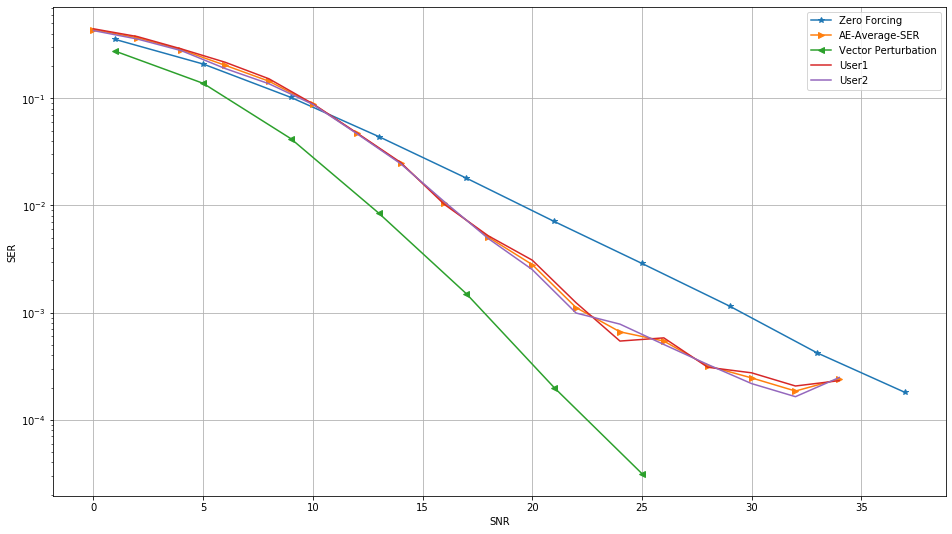

In [9]:
plt.figure(figsize=(16,9))
zero_forcing=np.array([0.354,0.209,0.102,0.044,0.01799,0.0071,0.00288,0.00115,0.00042,0.00018])
vertor_per=np.array([0.275,0.138,0.042,0.0085,0.0015,0.0002,3.15e-5])
plt.semilogy(np.arange(1,38,4), zero_forcing, '-*',label='Zero Forcing')
plt.semilogy(SNR_arr, SER, '->',label='AE-Average-SER')
plt.semilogy(np.arange(1,26,4), vertor_per,'-<', label='Vector Perturbation')
plt.semilogy(SNR_arr, SER1, label='User1')
plt.semilogy(SNR_arr, SER2, label='User2')
plt.xlabel('SNR')
plt.ylabel('SER')
plt.legend()
plt.grid()

